In [3]:
import os
import sys
sys.path.append('..')
import scripts.preprocessing as proc
import scripts.plot_utils as plot
#from scripts.biomass_export import *
from omegaconf import OmegaConf

import joblib
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
from matplotlib import colors
from matplotlib.lines import Line2D
from cartopy.feature import OCEAN, RIVERS
from cmap import Colormap

from scripts.plot_utils import *

from cmap import Colormap, Color

%load_ext autoreload 
%autoreload 2

cfg = OmegaConf.load('../configs/glob_config.yaml')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Clustering

In [5]:
def plot_clustered_space(train_data, labels, pipeline, axs, fontsize = 13):

    cols = map_colors_to_labels(train_data, labels)

    cmap = colors.ListedColormap(cols)

    # CENTER B PLOT
    axs["B"].set_xlabel("$\Delta$Chl [mg m$^{-3}$]", fontsize = fontsize)
    axs["B"].set_ylabel("$\Delta$SST [°C]", fontsize = fontsize)
    
    axs["B"].plot(train_data["chl"], train_data["sst"], ".", 
                  markersize = 3, alpha = .7, zorder = -2,
                 color = "dimgray")
    
    
    yabs_max = abs(max(axs["B"].get_ylim(), key=abs))
    xabs_max = abs(max(axs["B"].get_xlim(), key=abs))
    
    axs["B"].set_ylim(ymin=-yabs_max, ymax=yabs_max)
    axs["B"].set_xlim(xmin=-xabs_max, xmax=xabs_max)
    
    axs["B"].hlines(0, xmin = -xabs_max, xmax = xabs_max, color = "dimgray", linestyle = "dashed", linewidth = .5)
    axs["B"].vlines(0, ymin = -yabs_max, ymax = yabs_max, color = "dimgray", linestyle = "dashed", linewidth = .5)
    h = 0.02  # step size of the mesh
    
    xx, yy = np.meshgrid(np.arange(-xabs_max, xabs_max, h), np.arange(-yabs_max, yabs_max, h))
    Z = pipeline.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    axs["B"].contour(xx, yy, Z, alpha=0.5, colors = "black", linewidths = .5)
    axs["B"].imshow(
            Z,
            interpolation="nearest",
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=cmap,
            aspect="auto",
            origin="lower",
            zorder = -1, alpha = 0.5
        )
    
    centroids = pipeline["km"].cluster_centers_

    for c, i in zip(cols.items(), ['A', 'B', 'C', 'D']):
        if c == 'green':
            axs["B"].text(20, -4, str(i), ha = "center", va = "center", size = 15, 
                          color = c, path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        elif c == 'royalblue':
            axs["B"].text(-5, -6, str(i), ha = "center", va = "center", size = 15, 
                          color = c, path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        elif c == 'salmon':
            axs["B"].text(-20, 4, str(i), ha = "center", va = "center", size = 15, 
                          color = c, path_effects=[pe.withStroke(linewidth=1, foreground="black")])
        elif c == 'yellow':
            axs["B"].text(0, 0, str(i), ha = "center", va = "center", size = 15, 
                          color = c, path_effects=[pe.withStroke(linewidth=1, foreground="black")])

    
    chl_x = np.linspace(train_data["chl"].min(), train_data["chl"].max(), 50)
    sst_x = np.linspace(train_data["sst"].min(), train_data["sst"].max(), 50)

    
    # UPPER CHL KERNEL PLOT
    axs["A"].set_xticks([])
    axs["A"].set_xlim(xmin=-xabs_max, xmax=xabs_max)
    axs["A"].hist(train_data["chl"], alpha = .5, density = True, bins = 20, color = 'grey')
    axs["A"].vlines(0, ymin = 0, ymax = max(axs["A"].get_ylim(), key=abs), 
                    color = "dimgray", linestyle = "dashed", linewidth = .5)
    
    
    # RIGHT SST KERNEL PLOT
    axs["C"].set_yticks([])
    axs["C"].set_ylim(ymin=-yabs_max, ymax=yabs_max)
    #axs["C"].plot(sst_kde(sst_x), sst_x, color = "black")
    axs["C"].hist(train_data["sst"], alpha = .5, density = True, bins = 20, orientation = "horizontal", color = 'grey')
    axs["C"].hlines(0, xmin = 0, xmax = max(axs["C"].get_xlim(), key=abs), 
                    color = "dimgray", linestyle = "dashed", linewidth = .5)
    
    
    # UPPER RIGHT POPULATION PLOT
    axs["D"].set_ylim([0,50])
    axs["D"].set_yticks([0, 25, 50])
    counts = pd.DataFrame({"labels" : labels}).value_counts().sort_index()
    perc_counts = counts / len(labels) * 100
    
    axs["D"].bar(range(len(centroids)), perc_counts, color = cols, edgecolor = "black", alpha = 0.7)
    axs["D"].set_xticks(range(0, len(perc_counts)))
    axs["D"].xaxis.set_ticks_position('none') 
    axs["D"].tick_params(axis='x', which='major', pad=-2)
    axs["D"].yaxis.tick_right()
    axs["D"].set_yticklabels(["0%", "25%", "50%"])

    return axs

from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_fils(ax, date, folder_path, group_idx, norm_chl, norm_sst, bigbox):
    
    region = proc.read_region_input_files(os.path.join(folder_path, 'regions.input'))

    bathymetry = xr.open_dataarray('../../data/processed/bathymetry.nc')

    boxes = [box for boxes in region.values() for box in boxes]
    groups = proc.obtain_boxes_grouping(region)[group_idx]


    chl = proc.crop_region('../../data/processed/chl_2003-2023.zarr', box = bigbox)
    sst = proc.crop_region('../../data/processed/sst_2003-2023.zarr', box = bigbox)

    bathy_mask = crop_square(bathymetry, box = bigbox, engine = 'netcdf4') 
    chl, sst = chl.where(bathy_mask < cfg.ref_depth), sst.where(bathy_mask < cfg.ref_depth)


    c_chl = ax[0].contourf(chl.longitude, chl.latitude, chl.sel(time = date), 
                           cmap = Colormap('chrisluts:I_Forest').to_mpl(), 
                           norm = norm_chl, 
                           extend = 'max', 
                           levels = np.linspace(0, norm_chl.vmax, 50))
    
    c_sst = ax[1].contourf(sst.longitude, sst.latitude, sst.sel(time = date), 
                           cmap = Colormap('cmocean:balance').to_mpl(), 
                           norm = norm_sst, 
                           extend = 'both', 
                           vmin = norm_sst.vmin,
                           vmax = norm_sst.vmax,
                           levels = np.linspace(norm_sst.vmin, norm_sst.vmax, 50))

    for idx in groups:
        if 'pacific' in folder_path:
            region_name = 'pacific'
        elif 'atlantic' in folder_path:
            region_name = 'atlantic'
        else:
            raise ValueError('No region found')
        mask = xr.open_dataarray(os.path.join(folder_path, f'outputs/streamers_masks/box_{idx}.nc')).sel(time = date).astype(int)
        warm_mask = xr.open_dataarray(f'{region_name}/warm_fils/box_{idx}.nc').sel(time = date).astype(int)
        cold_mask = mask - warm_mask

        # Combine masks into a single mask: 0 = background, 1 = red, 2 = blue
        combined_mask = warm_mask * 1 + cold_mask * 2

        # Define a custom colormap
        cmap = ListedColormap(['white', Color('red'), Color('blue')])
        norm = BoundaryNorm([0, 1, 2, 3], cmap.N)  # Define boundaries for color mapping
        for a in ax[:2]:
            a.contour(chl.longitude, chl.latitude, bathy_mask, [cfg.ref_depth], colors = "red", linestyles = "solid", linewidths = .6)
            a.contour(mask.longitude, mask.latitude, mask, levels = [0.1, 1], colors = 'black')
            a.set_xlim([bigbox[0], bigbox[1]])
            a.set_ylim([bigbox[2], bigbox[3]])

        
        mesh = ax[2].pcolormesh(
            combined_mask.longitude, combined_mask.latitude, combined_mask,
            cmap=cmap, norm = norm
        )
        ax[2].set_xlim([bigbox[0], bigbox[1]])
        ax[2].set_ylim([bigbox[2], bigbox[3]])


    cb_chl = plt.colorbar(c_chl, ax = ax[0], orientation = 'horizontal', shrink = .8)
    cb_chl.set_label(label = 'Chlorophyll concentration [mg m$^{-3}$]', fontsize = 12)
    cb_sst = plt.colorbar(c_sst, ax = ax[1], orientation = 'horizontal', shrink = .8)
    cb_sst.set_label(label = 'Sea surface temperature [°C]', fontsize = 12)
    
    cb_mesh = plt.colorbar(mesh, ax=ax[2], orientation = 'horizontal', shrink = .8, label='')

    cb_chl.ax.set_xticks(np.arange(0, 3.5, 0.5))
    cb_sst.ax.set_xticks(np.arange(10, 30, 5))
    cb_mesh.ax.set_xticks([1.5, 2.5], labels = ['$\Delta$SST $\geq$ 0', '$\Delta$SST < 0'], fontsize = 12)

    handles = [Line2D([0], [0], linestyle='solid', label = f'Reference depth = {cfg.ref_depth} m', color = 'red'),
            Line2D([0], [0], linestyle='solid', label = f'Streamers mask', color = 'black')]
    ax[0].legend(handles = handles, loc = 'lower left')#, ncol=2, prop = {'size' : 20})
    return ax

def map_colors_to_labels(train_data, labels):
    
    colors_list = ["yellow", "red", "blue", "green"]

    
    cold_cluster = labels[np.argmin(train_data["sst"])]
    filament_cluster = labels[np.argmax(train_data["chl"])]
    warm_cluster = labels[np.argmax(train_data["sst"])]
    if filament_cluster == cold_cluster:
        filtered_train = train_data.iloc[labels != filament_cluster]
        filtered_labels = labels[labels!=filament_cluster]
        cold_cluster = filtered_labels[np.argmin(filtered_train["sst"])]
    
    # Identify the last remaining cluster
    all_clusters = set({0,1,2,3})
    remaining_cluster = list(all_clusters - {filament_cluster, cold_cluster, warm_cluster})[0]

    # Assign colors
    cluster_colors = {
        "green" : filament_cluster,
        "royalblue" : cold_cluster,
        "salmon" : warm_cluster,
        "yellow" : remaining_cluster
    }
    
    cluster_colors = {color: number for color, number in sorted(cluster_colors.items(), key=lambda item: item[1])}

    return cluster_colors

/data01/benassi/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/data01/benassi/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/data01/benassi/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/data01/benassi/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/data01/benassi/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/data01/benassi/miniconda3/lib/pyth

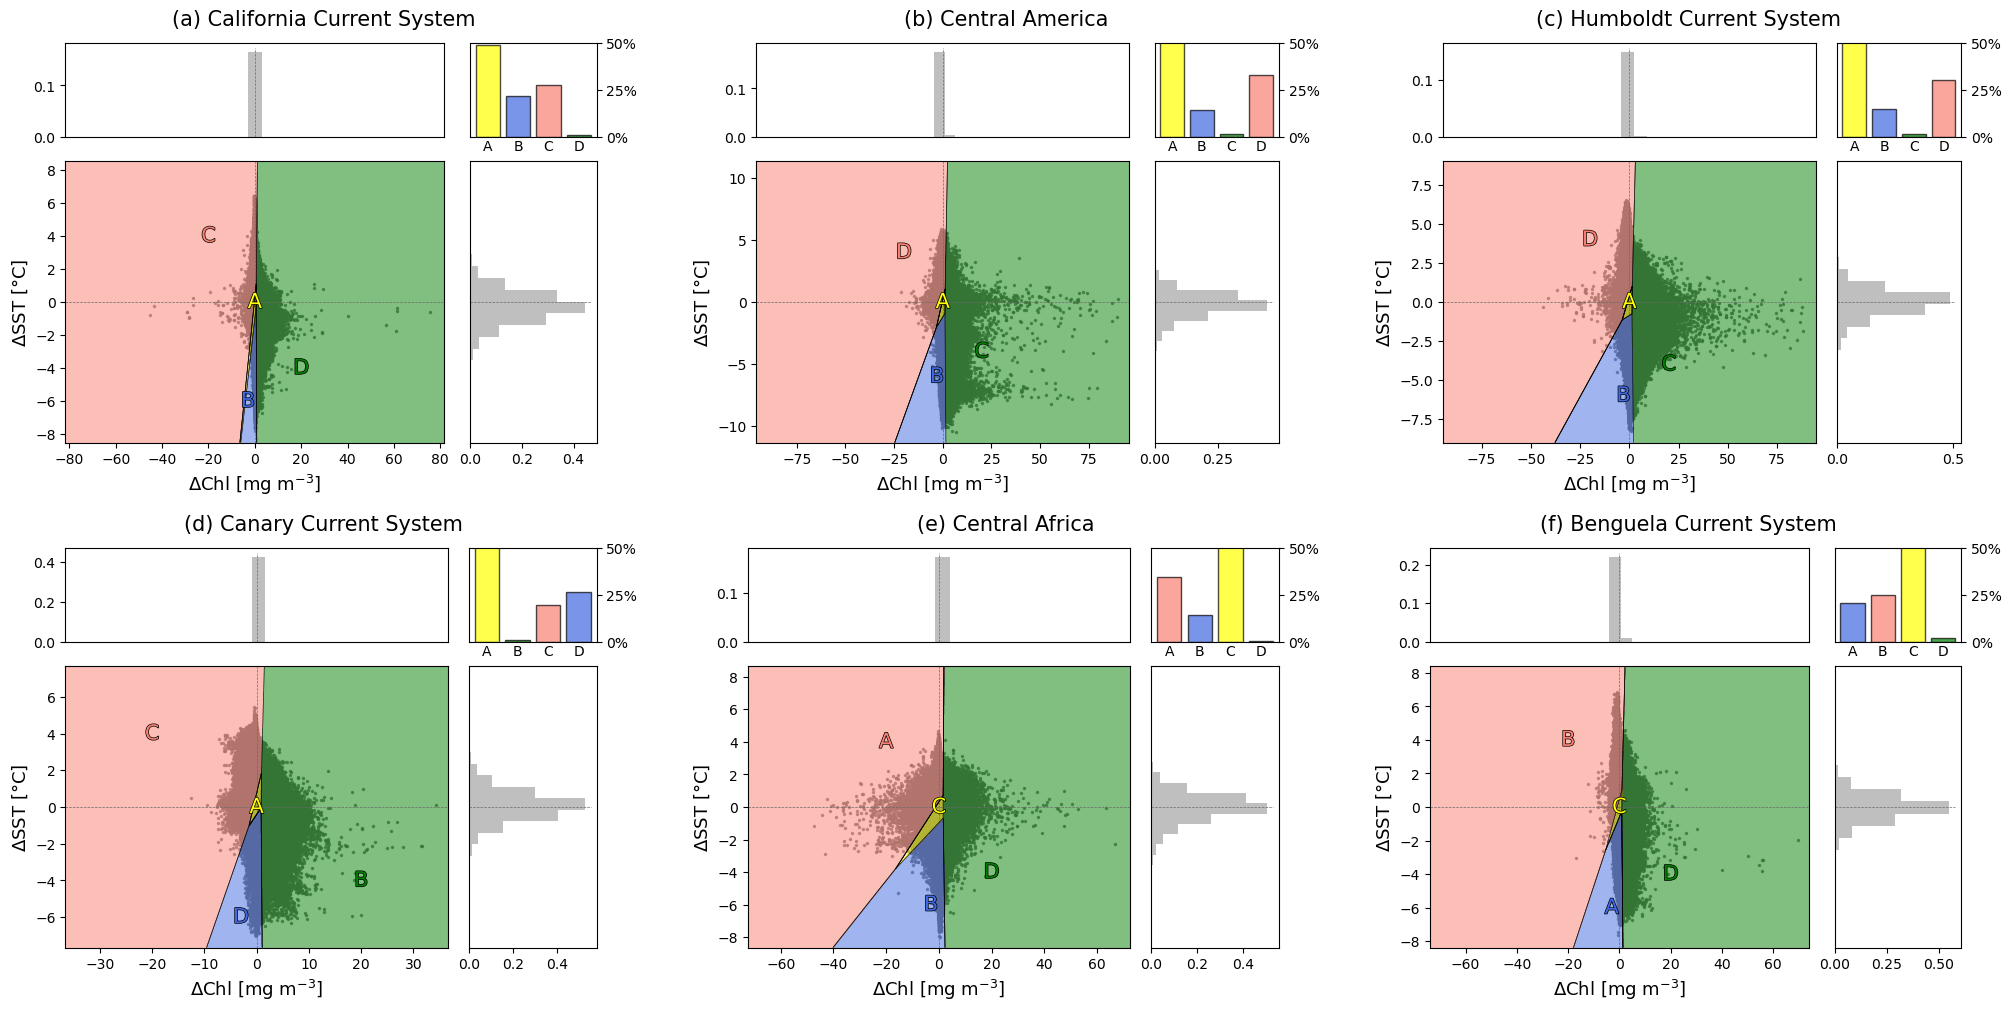

In [6]:
fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(2, 3, wspace=0.07)

atl_path = "../sensitivity_test_years/atlantic/10years/"
pac_path = "../sensitivity_test_years/pacific/10years/"

atl_regions = [c for c in proc.read_region_input_files(os.path.join(atl_path, 'regions.input')).keys()]
pac_regions = [c for c in proc.read_region_input_files(os.path.join(pac_path, 'regions.input')).keys()]

regions = [pac_regions,
        atl_regions]

paths = [pac_path, 
         atl_path]

titles = [["(a) California Current System", "(b) Central America", "(c) Humboldt Current System"],
          ["(d) Canary Current System", "(e) Central Africa", "(f) Benguela Current System"]]

for row in range(subfigs.shape[0]):
    for col in range(subfigs.shape[1]):

        train_data = pd.read_csv(f"{os.path.join(paths[row], 'outputs/train_data/')}{regions[row][col]}.csv", index_col = 0)
        labels = np.load(f"{os.path.join(paths[row], 'outputs/labels/')}{regions[row][col]}.npy")
        pipeline = joblib.load(f"{os.path.join(paths[row], 'outputs/models/')}{regions[row][col]}.joblib")
        axs = subfigs[row, col].subplot_mosaic("""AAAD
                            BBBC
                            BBBC
                            BBBC""")
        plot.plot_clustered_space(train_data, labels, pipeline, axs)
        subfigs[row, col].suptitle(titles[row][col], fontsize = 15)

plt.savefig("images/clustered_spaces.jpg", bbox_inches = "tight")